In [ ]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Tarea 1 - Momentos Estadísticos en Series de Tiempo Financieras
### Diego Andrés Peñaranda Correa 201910807
1. Descarga de la serie de precios de dos activos estándares: Stock y un Bono con fechas 1 enero 2018 al 1 enero 2021.
2. Análisis de las series:
• Media, Varianza, Sesgo y Curtosis de log-rendimientos.
• Realice pruebas de hipótesis de cero: media, sesgo, y curtosis. 
  Prueba de normalidad JB o Shapiro
• Con base a los cuatro momentos estadísticos, comente y compare las series.
• Entregar documento tipo pdf autocontenido con código, resultados e interpretaciones

### 1. Parte 1: Obtención de datos y grafico de rendimientos.
### 2. Estaísticas Basicas y Análisis Momentos: media, sesgo y curtosis.
### 3. Visualización de distribuciones

In [1]:
library(fBasics)
library(PerformanceAnalytics)
library(xts)
library(quantmod)
library(ggplot2)
library(tseries)
library(dygraphs)
options(warn = - 1) 

## 1. Datos
Se toman los datos con la herramienta getSymbols desde la base de datos de Yahoo Finance, se tiene en cuenta que los rendimientos diarios sean descargados logarítmicos. Las fechas en el intervalo del 1 enero 2018 al 1 enero 2021.

In [36]:
start<-format(as.Date("2018-01-01"),"%Y-%m-%d")
end<-format(as.Date("2021-01-01"),"%Y-%m-%d")
rend<-function(simbolo) {
  ##---------Obtener precios de yahoo finance:
  datos<-getSymbols(simbolo,  from=start, to= end, auto.assign = FALSE)
  ##---------eliminar datos faltantes:
  datos<-na.omit(datos)
  ##--------Mantener el precio de interés:
  datos<-datos[,4]
  ##--------Rendimientos logarítmicos:
  rend<-periodReturn(datos, period = "daily", type='log')                                              
  #------ --Para hacer dtos accesibles  GLobal ENv:
  assign(simbolo, rend, envir = .GlobalEnv)
}


In [37]:
rend("EC") #Accíon Ecopetrol SA
rend("^FVX")  #(^FVX) Treasury Yield 5 Years - Bono del tesoro de Estados Unidos a 5 años

head(EC) #primeros cinco datos de la acción Ecopetrol
head(`^FVX`) #primeros cinco datos de la serie del Bono 5Y US

In [22]:
rends<-merge.xts(EC, `^FVX`)
colnames(rends)<-c("EC", "^FVX")
dygraph(rends, main = "EC, `^FVX` Rendimientos") %>%
  dyAxis("y", label = "Rend %") %>%
  dyOptions(colors = RColorBrewer::brewer.pal(4, "Set1"))

Podemos ver de la gráfica de rendimientos que la serie de Ecopetrol para el periodo evaluado es más volatil que el bono a 5 años del tesoro de Estados Unidos, esto entre 2018 hasta mediados de 2019. Sin embargo, dicho bono registro una alta volatilidad reflejando impactos en la economía de Estados Unidos especialmente desde marzo de 2020 en adelante, esto principalmente se puede justificar por el inicio de la pandemia y su significativo impacto en la economía mundial, si bien esta afecto todo tipo de inversiones, en el gráfico se puede ver que la actividad de Ecopetrol tuvo un menor impacto que el bono de la economía en el periodo de inicio de pandemia. 

## 2. Estadísticas y análisis momentos

Para medir estadísticamente la significancia del sesgo, se usan las siguientes pruebas de hipótesis:

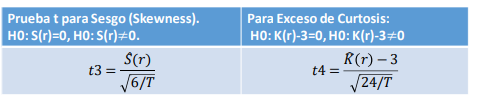

Donde S(r) y K(r) son los resultados de las funciones en R:

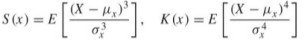

Donde en el caso de curtosis, el programa calcula el exceso de curtosis. Inicialmente se calculan los primeros momentos, además se define si la media de los rendimientos es o no igual a cero:

In [23]:
basicStats(EC) ## Resumen estadisticos

In [24]:
mean(EC)
var(EC)
stdev(EC) # Desv Std

A continuación, se evalua si la media de los rendimientos es igual o diferente de cero, a un nivel de significación alfa=0.05.

In [25]:
t.test(EC)  # Prueba que H0: media real = 0

Se encuentra que el p-value es mayor al nivel de significancia, por tanto, la prueba esta en zona de no rechazo y la hipotesis nula inicial (H0) no se puede rechazar. En resumen, la media real es cero. Continuamos con la prueba de sesgo o tercer momento:

In [26]:
s3=skewness(EC)  #Sesgo
T=length(EC) # N
t3=s3/sqrt(6/T) # Prueba de sesgo
t3

El sesgo es negativo. Ahora se determina la significancia de dicho sesgo con prueba de hpotesis mediante el calculo del p-valor:

In [27]:
pp=2*pt(abs(t3), T-1, lower=FALSE) # H0: Sesgo=0 
pp


Como el pp es menor al nivel de significancia 0.05 se encuentra la H0 en zona de rechazo, por lo cual se puede concluir que el sesgo es estadísticamente diferente de cero. 
Ahora validamos en el caso de la curtosis:

In [10]:
s4=kurtosis(EC)
s4
t4=s4/sqrt(24/T) # Prueba de curtosis, en exceso
t4
pv=2*(1-pnorm(t4)) # p-valor, H0:curtosis=0
pv


Al ser el p-valor de esta prueba menor al alpha de significancia se puede rechazar la hipotesis nula, es decir, la curtosis es distinta de cero. Finalmente, se determina si la distribución es o no normal. Podemos usar Jarque Bera o Shapiro. En este caso usamos JB:

In [40]:
normalTest(EC,method='jb') # Prueba Jaque Bera, H0: Normal

El p-value resultante esta dentro de la zona de rechazo, por lo cual se rechaza H0, es decir, que la distribución no es normal.


Ahora graficamos el comportamiento de la distribución para esta acción:

In [12]:
library(PerformanceAnalytics)
par(mfrow=c(1,1))
chart.Histogram(EC, methods = c("add.normal", "add.density"), colorset = c("gray", "blue", "red"))
legend("topright", legend = c("Hist-EC" ,"Ecopetrol dist","dnorm Ecopetrol"), col=c("gray", "blue", "red"), lty=1, cex = 0.7)

Se puede concluir a partir de esta visualiación que la acción de Ecopetrol SA esta dominado por su clima de incertidumbre en los últimos años (relacionados a la serie de tiempo analizada de 2018 a 2020), esto respecto a los pocos resultados de nuevas reservas durante la exploración. Respecto a la gráfica se encuentra un comportamiento leptocúrtico, con una media de rendimientos estadísticamente igual a cero, sesgada negativamente y con un exceso de curtosis positivo significativo; lo que se interpreta como una acción altamente riesgosa. Adicionalmente por ser una empresa del sector petrolero pública es altamente sensible a este mercado que presenta alta volatilidad y riesgo, este factor puede explicar complementariamente el comportamiento evidenciado.

### A continuación se evaluan los momentos y se hace el análisis para el bono del tesoro de Estados Unidos a 5 años:
* rend("^FVX")
### Además, se incluirán conclusiones del nivel de riesgo del bono analizado

In [13]:
basicStats(`^FVX`) ## Resumen estadisticos
mean(`^FVX`)
var(`^FVX`)
stdev(`^FVX`) # Desv Std

In [14]:
t.test(`^FVX`)  # Prueba que H0: mean return = 0

Como resultante el p-value de esta prueba esta en zona de no rechazo, por lo cual no se puede rechazar la H0, es decir, la media es estadísticamente igual a 0. Se continua ahora con el sesgo:

In [15]:
s3=skewness(`^FVX`)  #Sesgo
T=length(`^FVX`) # N
t3=s3/sqrt(6/T) # Prueba de sesgo
t3

En este caso lo relevante de este resultado es que el sesgo es negativo. Se sigue ahora con la prueba de hipotesis del sesgo.

In [16]:
pp=2*pt(abs(t3), T-1, lower=FALSE) # H0: Sesgo=0 
pp

Dado que el p-value es mayor a un nivel de significacia del 5% se encuentra que dicho p-value obtenido esta en zona de no rechazo, es decir, no se puede rechazar la H0 y se puede concluir que el sesgo es cero. Finalizamos entonces con el último análisis de momento estadístico (curtosis)

In [17]:
s4=kurtosis(`^FVX`)
s4
t4=s4/sqrt(24/T) # Prueba de curtosis, en exceso
t4
pv=2*(1-pnorm(t4)) # p-valor, H0:curtosis=0
pv

La curtosis es positiva, además, el p-valor de esta prueba es menor al alpha de significancia, por tanto se puede rechazar la hipotesis nula, es decir, la curtosis es distinta de cero. Finalmente, se determina si la distribución es o no normal. Podemos usar Jarque Bera o Shapiro. En este caso usamos JB:

In [18]:
normalTest(`^FVX`,method='jb') # Prueba Jaque Bera, H0: Normal

Al aplicar la prueba de normalidad para la distribución se uso el metodo de Jarque - Bera, esta muestra un p-value menor al valor de significancia del 5%, es decir, la hipotesis nula se rechaza y se puede inferir que la distribución no es normal. Finalmente, se grafica la distribución del bono evaluado.

In [19]:
library(PerformanceAnalytics)
par(mfrow=c(1,1))
chart.Histogram(`^FVX`, methods = c("add.normal", "add.density"), colorset = c("gray", "blue", "red"))
legend("topright", legend = c("Hist-5Y Bond" ,"US 5Y-Bond dist","dnorm 5Y-Bond"), col=c("gray", "blue", "red"), lty=1, cex = 0.7)

Así, podemos concluir que el bono de tesoro de Estados Unidoas a 5 años esta dominado por un comportamiento leptocúrtico, colas aplanadas en los extremos, donde con una media de rendimientos su distribución es estadísticamente igual a cero. Además, aunque levemente, esta sesgada positivamente y con un exceso de curtosis positivo significativo; lo que se interpreta como un índice atractivo para un inversionista con aversión al riesgo. También se puede explicar esto por ser una bono de una economía estable, así el comportamiento aquí descrito es atractivo para inversión preferente de bajo riesgo, esto dada su poca volatilidad económica en general.